**Модель соц. динаміки.**

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step


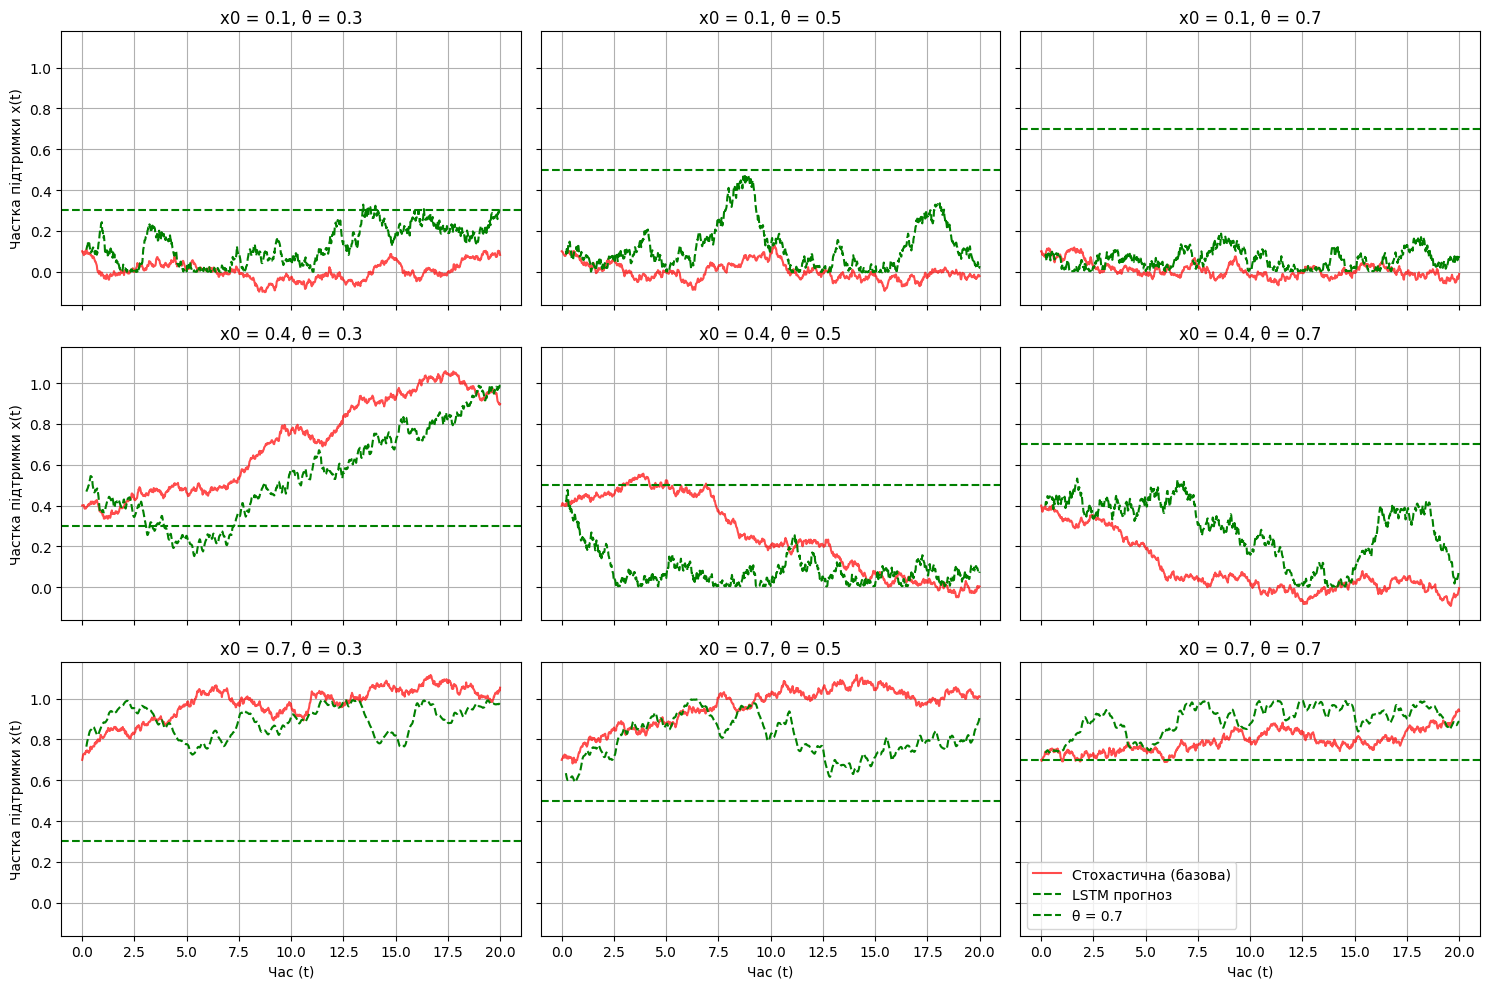

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Параметри моделі
k = 1.0  # Коефіцієнт швидкості динаміки
x0_values = [0.1, 0.4, 0.7]  # Різні початкові значення x0
theta_values = [0.3, 0.5, 0.7]  # Різні критичні пороги theta

# Стохастична модель (базова)
def stochastic_dynamics(x0, theta, sigma_noise=0.05, n_steps=1000, T=20):
    dt = T / n_steps
    t_stoch = np.linspace(0, T, n_steps)
    x_stoch = np.zeros(n_steps)
    x_stoch[0] = x0

    for i in range(1, n_steps):
        dW = np.random.normal(0, np.sqrt(dt))
        f = k * x_stoch[i-1] * (1 - x_stoch[i-1]) * (x_stoch[i-1] - theta)
        x_stoch[i] = x_stoch[i-1] + f * dt + sigma_noise * dW

    return t_stoch, x_stoch

# модель для навчання LSTM (враховує трендові стрибки та затухання)
def enhanced_stochastic_dynamics(x0, theta, sigma_noise=0.1, n_steps=1000, T=20):
    dt = T / n_steps
    t_stoch = np.linspace(0, T, n_steps)
    x_stoch = np.zeros(n_steps)
    x_stoch[0] = x0
    trend_jump_prob = 0.05  # Йм. трендового зростання
    decay_rate = 0.005  # Швидкість затухання

    for i in range(1, n_steps):
        dW = np.random.normal(0, np.sqrt(dt))
        f = k * x_stoch[i-1] * (1 - x_stoch[i-1]) * (x_stoch[i-1] - theta)

        # Випадкові стрибки популярності
        if np.random.rand() < trend_jump_prob and x_stoch[i-1] > 0.2:
            f += 0.2

        # Затухання популярності, якщо довго не росте
        if x_stoch[i-1] < 0.3:
            f -= decay_rate * x_stoch[i-1]

        x_stoch[i] = max(0, min(1, x_stoch[i-1] + f * dt + sigma_noise * dW))

    return t_stoch, x_stoch

# Підготовка даних для LSTM
def prepare_lstm_data(x, time_steps=10):
    X = np.array([x[i:i+time_steps] for i in range(len(x)-time_steps)])
    y = x[time_steps:]
    X = X.reshape((X.shape[0], X.shape[1], 1))
    return X, y

# Створення та навчання LSTM
def create_lstm_model(input_shape):
    model = Sequential([
        LSTM(100, activation='relu', input_shape=input_shape, return_sequences=True),
        LSTM(50, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Візуалізація результатів
fig, axes = plt.subplots(len(x0_values), len(theta_values), figsize=(15, 10), sharex=True, sharey=True)

for i, x0 in enumerate(x0_values):
    for j, theta in enumerate(theta_values):
        # Стохастична модель (базова)
        t_stoch, x_stoch = stochastic_dynamics(x0, theta)

        # Дані для навчання LSTM
        t_lstm, x_lstm = enhanced_stochastic_dynamics(x0, theta)
        X_lstm, y_lstm = prepare_lstm_data(x_lstm)

        # Створення та навчання моделі LSTM
        model = create_lstm_model((X_lstm.shape[1], X_lstm.shape[2]))
        model.fit(X_lstm, y_lstm, epochs=100, batch_size=32, verbose=0)

        # Прогноз LSTM
        y_pred_lstm = model.predict(X_lstm)

        # Графік
        ax = axes[i, j]
        ax.plot(t_stoch, x_stoch, 'r-', alpha=0.7, label="Стохастична (базова)")
        ax.plot(t_lstm[10:], y_pred_lstm, 'g--', label="LSTM прогноз")
        ax.axhline(y=theta, color='g', linestyle='--', label=f"θ = {theta}")
        ax.set_title(f"x0 = {x0}, θ = {theta}")
        ax.grid(True)
        if i == len(x0_values) - 1:
            ax.set_xlabel("Час (t)")
        if j == 0:
            ax.set_ylabel("Частка підтримки x(t)")

plt.legend()
plt.tight_layout()
plt.show()


**Базова модель**: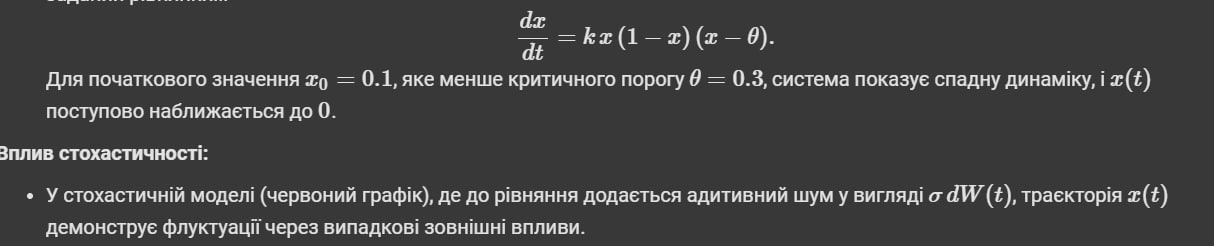

**Запропоновані модифікації з використанням LSTM**

Для покращення моделі та більш реалістичного відображення впливу соціальних мереж на поширення ідей було використано рекурентну нейромережу (LSTM). Основні модифікації:
-Облік трендових стрибків – якщо підтримка ідеї набирає певний рівень, поширення може різко зрости.
-Моделювання затухання популярності – якщо ідея не набирає достатньої підтримки тривалий час, вона поступово втрачає актуальність.

**Обґрунтування використання**

LSTM (Long Short-Term Memory) – це різновид рекурентних нейромереж, здатний запам’ятовувати довготривалі залежності. У контексті моделювання соц. мереж цей підхід дозволяє: навчатися на минулих трендах та передбачати майбутню динаміку.

LSTM підходить для таких систем, де поведінка залежить від попереднього стану, як у випадку соціальної динаміки.

**Математичне формалювання:**

Комбінуємо стохастичну модель та LSTM для прогнозування динаміки підтримки ідеї:

$
\hat{x}(t+1) = \text{LSTM}(x_{t-T}, x_{t-T+1}, ..., x_t)
$

де \( T \) — довжина вікна попередніх значень, які використовуються для прогнозу.

При цьому LSTM навчається на даних, згенерованих за стохастичною моделлю:

$
dx = k \cdot x (1 - x) (x - \theta) dt + \sigma dW + f_{\text{social}}(x, t)
$

де $ f_{\text{social}}(x, t) $ — функція, що враховує додаткові соціальні ефекти(стрибки-тренди-затухання).

**Порівняння моделей:**
Модифікована модель краще відображає реальні соціальні процеси завдяки трендам і затуханням. LSTM вловлює загальні закономірності, хоча і не може точно передбачити окремі випадкові стрибки.

Оригінальна модель більш передбачувана, але менш реалістична.

Підхід із гібридною моделлю дозволяє отримати баланс між математичною строгою моделлю і можливістю адаптації до соціальних процесів - впливу соц.мереж.

**Інтерпретація результатів:**
Базова модель: поступові зміни без раптових стрибків.
Модель без додаткових факторів добре описує процеси, де популярність чогось змінюється поступово, наприклад:
Розвиток інновацій – якщо технологія впроваджується рівномірно, без вірусних ефектів.
Така модель добре підходить для систем, де зміни є передбачуваними і поступовими.


Модифікована модель:
Популярність чогось може змінюватися не лише плавно, а й під впливом раптових подій в соц. мережах або зниження інтересу. Ця модель додає важливі особливості:
раптові трендові сплески – це може відображати ситуації, коли щось стає хайпом через зовнішні фактори.
Затухання популярності – відображає те, що інтерес до чогось поступово згасає. Процес стопориться, наприклад:гра, яка спочатку була хітом, поступово втрачає активних гравців, автоматично вона й не особливо згадується в соц. мережах, рейтинги падають.

Висновок: Модифікована модель краще пояснює реальні соціальні процеси, де є не лише плавні зміни, а й раптові коливання популярності.